## For project development. To be deleted.

### data_prep.py

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from datasets import Dataset
import pickle

In [3]:
data = pd.read_csv('../hanna_stories_annotations.csv')
data.head()

,Story ID,Prompt,Human,Story,Model,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,Worker ID,Assignment ID,Work time in seconds,Name
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,4,4,3,2,4,4,A2VE5IV9OD2SK1,3X87C8JFVHIT235KQ4UTS8264I6SQJ,579.0,NaN
1,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,5,5,1,3,4,1,A1IZ4NX41GKU4X,3DR23U6WEGL5K0SU6D4J8W9EM9LTE7,82.0,none
2,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,2,2,3,2,2,3,A264NN7JBX4UDQ,3UJ1CZ6IZSW49HMM6C6QUX7F7UV5SA,273.0,none
3,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...","“Dad, you 're on TV again !” I heard Eric 's v...",Human,5,5,3,4,4,4,A3CFNUD7VR2E1E,317HQ483IIZJ5SPW508YKC1EP6RINX,117.0,Eric
4,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...","“Dad, you 're on TV again !” I heard Eric 's v...",Human,5,4,4,4,4,4,A2VE5IV9OD2SK1,3T3IWE1XGHUUH3IZF4ZJ2DYS57WQTT,751.0,Eric


In [4]:
# group data by first 5 columns and average metric columns
data_agg = data.groupby(data.columns[:5].tolist(), as_index=False).agg(
    Relevance=('Relevance', 'mean'),
    Coherence=('Coherence', 'mean'),
    Empathy=('Empathy', 'mean'),
    Surprise=('Surprise', 'mean'),
    Engagement=('Engagement', 'mean'),
    Complexity=('Complexity', 'mean')
    )
data_agg.head()

,Story ID,Prompt,Human,Story,Model,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,3.666667,3.666667,2.333333,2.333333,3.333333,2.666667
1,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...","“Dad, you 're on TV again !” I heard Eric 's v...",Human,5.000000,4.666667,4.000000,3.666667,3.666667,4.000000
2,2,A scientific study proves that all humans have...,"When Tyler entered the ward, his daughter Vale...","When Tyler entered the ward, his daughter Vale...",Human,4.666667,4.666667,4.000000,4.333333,4.000000,4.333333
3,3,Write a story about an elderly wizard and his ...,His body was failing. He had taken care of it ...,His body was failing. He had taken care of it ...,Human,3.666667,4.000000,3.000000,2.000000,3.666667,4.000000
4,4,"You have become death, destroyer of worlds.","I saw the button. It was simple, red, no words...","I saw the button. It was simple, red, no words...",Human,4.666667,5.000000,3.000000,4.666667,3.666667,3.666667


TODO:
- Consider not including Relevance beacause it's based on the story AND prompt 
- The final dataset should be a dictionary with three keys (train, validation, and test) each containg a dataset object. A dataset object contains a dictionary (with keys label and text) for each data entry.

In [57]:
metrics = ['Relevance', 'Coherence', 'Empathy', 'Surprise', 'Engagement', 'Complexity']

In [41]:
# round scores to nearest integer
#data_agg_rounded = data_agg.copy()

#for metric in metrics:
#    data_agg_rounded[metric] = data_agg_rounded[metric].round()


In [ ]:
#data_agg_rounded.head()

In [43]:
# combine scores to single label
y = data_agg.iloc[:, 5:11].agg(func=np.array, axis=1)

# isolate stories
X = data_agg.iloc[:, 3]

# train test split - no stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [60]:
# val test split
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=55)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

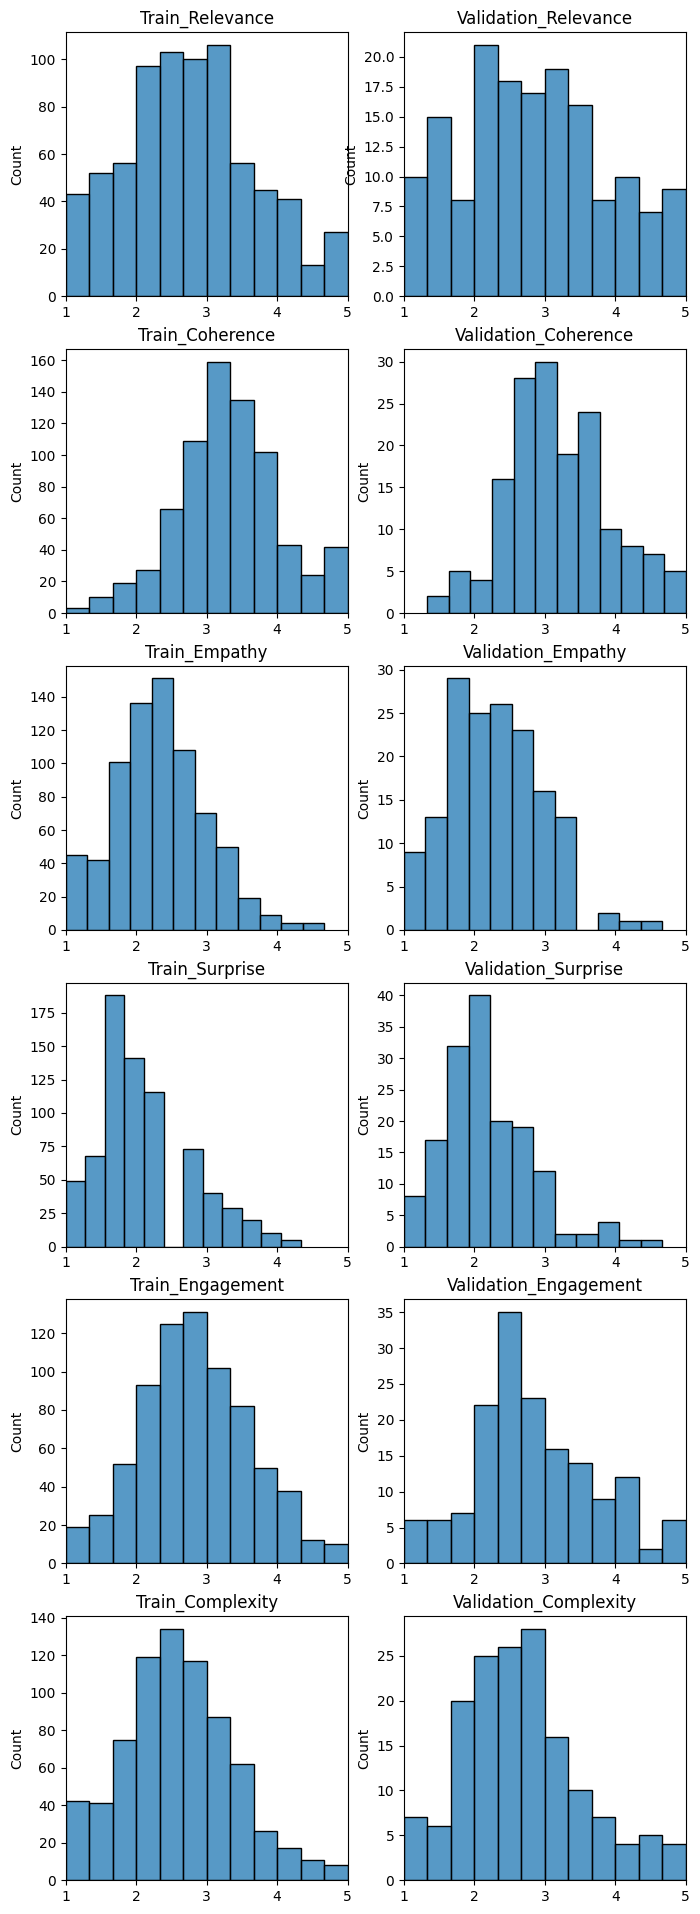

In [62]:
# plot distribution of scores in train and validation sets for each metric
fig, ax = plt.subplots(6, 2, figsize=(8, 24))
for i, metric in enumerate(metrics):
    sns.histplot([score[i] for score in y_train], bins=12, ax=ax[i, 0])
    sns.histplot([score[i] for score in y_val], bins=12, ax=ax[i, 1])
    ax[i, 0].set_title(f'Train_{metric}')
    ax[i, 0].set_xlim(1, 5)
    ax[i, 1].set_title(f'Validation_{metric}')
    ax[i, 1].set_xlim(1, 5)
plt.show()

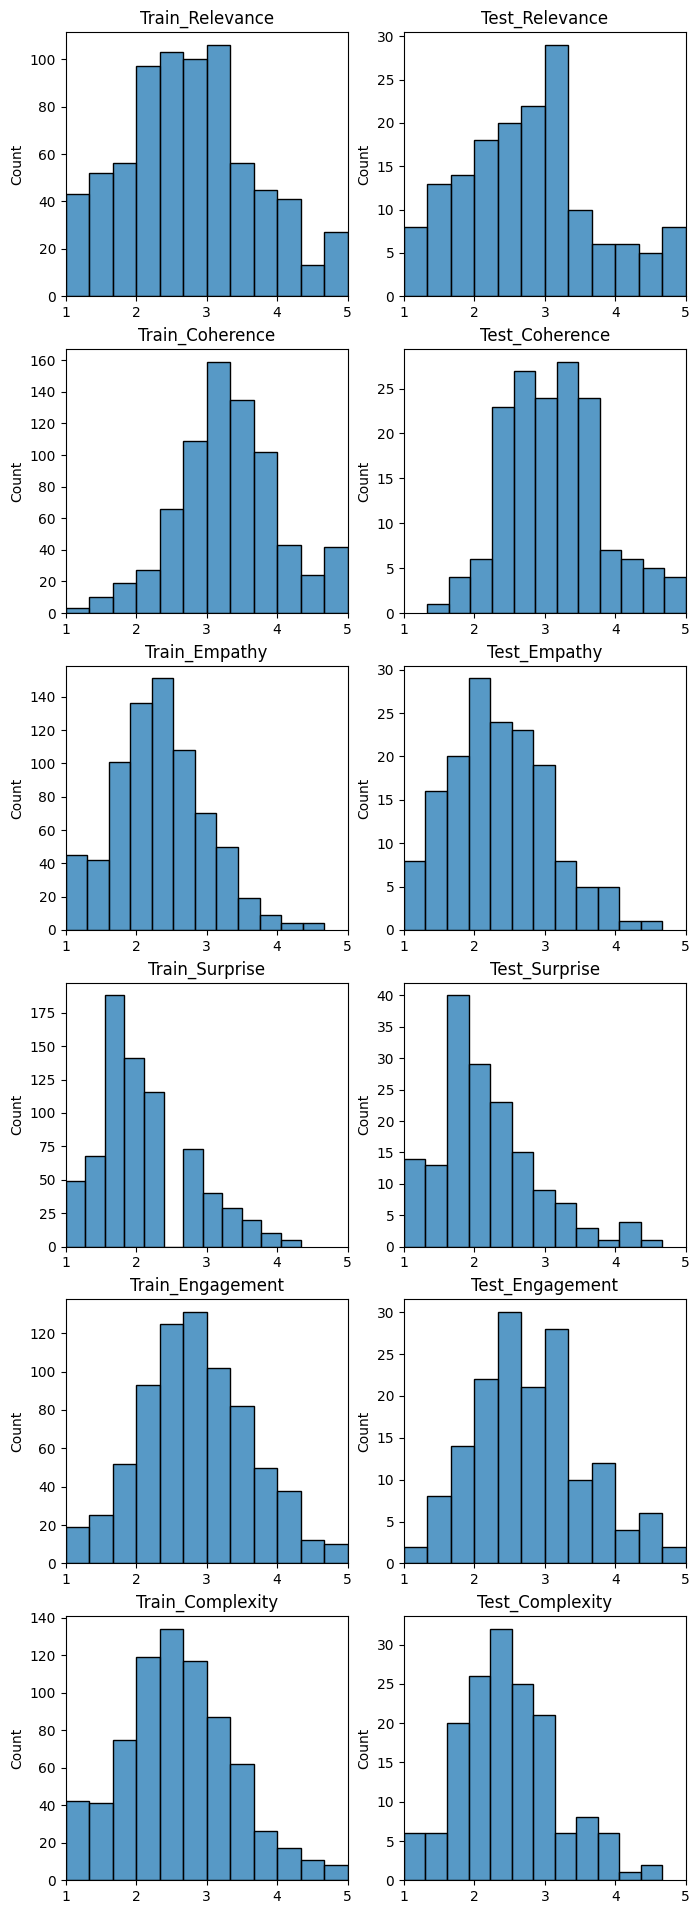

In [64]:
# plot distribution of scores in train and test sets for each metric
fig, ax = plt.subplots(6, 2, figsize=(8, 24))
for i, metric in enumerate(metrics):
    sns.histplot([score[i] for score in y_train], bins=12, ax=ax[i, 0])
    sns.histplot([score[i] for score in y_test], bins=12, ax=ax[i, 1])
    ax[i, 0].set_title(f'Train_{metric}')
    ax[i, 0].set_xlim(1, 5)
    ax[i, 1].set_title(f'Test_{metric}')
    ax[i, 1].set_xlim(1, 5)
plt.show()

In [66]:
train_dict = {'label': y_train, 'story': X_train}
ds_train = Dataset.from_dict(train_dict)
test_dict = {'label': y_test, 'story': X_test}
ds_test = Dataset.from_dict(test_dict)
val_dict = {'label': y_val, 'story': X_val}
ds_val = Dataset.from_dict(val_dict)

dataset = {'train': ds_train, 'test': ds_test, 'validation': ds_val}

In [71]:
# save dataset as pkl file
with open('../story_eval_dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)